In [2]:
from bigml.api import BigML
import numpy as np
from pandas import DataFrame, read_csv
import kaggle
import matplotlib.pyplot as plt

In [3]:
# On se connecte à BigML avec l'ID BigML, la key et l'id du projet

api = BigML('CorantinO', '77225993ed8676123a26c4cdaa13cfadadf71237', project = 'project/5d94a41242129f2e16000244')

In [6]:
# On importe nos deux fichiers csv train et test, modifiés, dans la source BigML

source_train = api.create_source('GMSCtrainmodif_v2.csv')
source_test = api.create_source('GMSCtestmodif_v2.csv')

# On créé notre dataset avec le train et le test

train_dataset = api.create_dataset(source_train)
test_dataset = api.create_dataset(source_test)

# On split notre dataset train full en 80-20

split_train = api.create_dataset(
    train_dataset, {"name": "GMSCfulltrainm_v2 | Training", "sample_rate": 0.8, "seed": "my seed"})
api.ok(split_train)

split_test = api.create_dataset(
    train_dataset, {"name": "GMSCfulltrainm_v2 | Test", "sample_rate": 0.8, "seed": "my seed", "out_of_bag": True})
api.ok(split_test)

True

In [7]:
# On créé nos Learning Curves

x_ensemble = []
y_ensemble = []
x_deepnet = []
y_deepnet = []

# Boucle de variation 10-100% 

for i in range(1,11):
    
# Data set de train par rapport à notre dataset split_train

    split_train_2 = api.create_dataset(split_train, {"name": "Split Train " + str(i/10), "sample_rate": i/10, "seed": "my seed"})    
    api.ok(split_train)  
    
# On crée un modèle Ensemble à partir du dataset split
    
    ensemble = api.create_ensemble(split_train_2, {"objective_field" : "SeriousDlqin2yrs", "name": "Ensemble " + str(i/10)})
    api.ok(ensemble)
    
# On évalue le modèle

    evaluation = api.create_evaluation(ensemble, split_test)
    api.ok(evaluation)
    
# On crée le modèle Deepnet à partir du dataset split

    deepnet = api.create_deepnet(split_train_2, {"objective_field" : "SeriousDlqin2yrs", "name": "Deepnet " + str(i/10)})
    api.ok(deepnet)
    
# On évalue le nouveau modèle

    evaluation_deepnet = api.create_evaluation(deepnet, split_test)
    api.ok(evaluation_deepnet)
    
# x pourcentage du split sur l'axe des abscisses et y valeur de l'AUC correspondante
    
    x_ensemble.append(i*10)
    y_ensemble.append(evaluation['object']['result']['model']['average_area_under_roc_curve'])
    
    x_deepnet.append(i*10)
    y_deepnet.append(evaluation_deepnet['object']['result']['model']['average_area_under_roc_curve'])
    
    i += 1

print(x_ensemble)
print(x_deepnet)
print(y_ensemble)
print(y_deepnet)

[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
[0.82724, 0.84078, 0.8468, 0.84813, 0.8524, 0.85332, 0.85424, 0.85369, 0.85459, 0.85291]
[0.83838, 0.83781, 0.83915, 0.83536, 0.8348, 0.82865, 0.84267, 0.836, 0.83185, 0.82404]


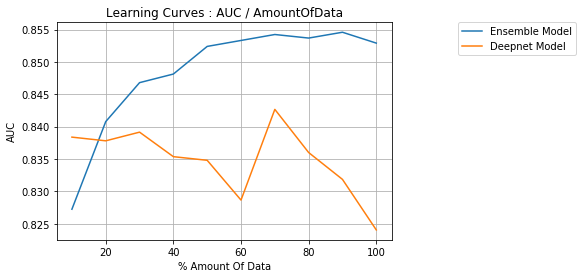

In [8]:
# On créé le graphique de comparaison entre les modèles Ensemble et Deepnet, avec l'AUC en fonction de la quantité de données

fig, ax = plt.subplots()
ax.plot(x_ensemble, y_ensemble, label = 'Ensemble Model')
ax.plot(x_deepnet, y_deepnet, label = 'Deepnet Model')
ax.set(xlabel = '% Amount Of Data', ylabel = 'AUC',  title = 'Learning Curves : AUC / AmountOfData')
plt.legend(bbox_to_anchor=(1.2, 1), loc='best', borderaxespad=0.)
ax.grid()
plt.show()